# [如何用Python和机器学习帮你决策？](http://www.jianshu.com/p/67a71e366516)
## 贷还是不贷：
每一行数据，都代表了之前的一次贷款信息。你琢磨了很久，终于弄明白了每一列究竟代表什么意思：

-    grade：贷款级别
-    sub_grade: 贷款细分级别
-    short_emp：一年以内短期雇佣
-    emp_length_num：受雇年限
-    home_ownership：居住状态（自有，按揭，租住）
-    dti：贷款占收入比例
-    purpose：贷款用途
-    term：贷款周期
-    last_delinq_none：贷款申请人是否有不良记录
-    last_major_derog_none：贷款申请人是否有还款逾期90天以上记录
-    revol_util：透支额度占信用比例
-    total_rec_late_fee：逾期罚款总额
-    safe_loans：贷款是否安全
最后一列，记录了这笔贷款是否按期收回。拿着以前的这些宝贵经验教训，主管希望你能够总结出贷款是否安全的规律。在面对新的贷款申请时，从容和正确应对。这里需要找的这种规律，可以用决策树来表达。

下面我们开始动手实践。用Python做个决策树出来，辅助我们判断贷款风险。

## 准备

你需要`loans.csv`这个文件。如果一切正常，请把它移动到咱们的工作目录里面。

## 代码

首先，我们新建一个Python 笔记本，起名叫做loans-tree。

In [1]:
#为了让Python能够高效率处理表格数据，我们使用一个非常优秀的数据处理框架Pandas。
import pandas as pd

#然后我们把loans.csv里面的内容全部读取出来，存入到一个叫做df的变量里面。
df = pd.read_csv('loans.csv')

#我们看看df这个数据框的前几行，以确认数据读取无误。因为表格列数较多，屏幕上显示不完整，我们向右拖动表格，看表格最右边几列是否也正确读取。
df.tail()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
46503,C,C4,0,11,MORTGAGE,19.76,debt_consolidation,60 months,0,1,70.1,0.0,1
46504,C,C4,0,8,RENT,15.70,car,36 months,0,1,38.7,0.0,1
46505,D,D3,1,1,RENT,7.56,major_purchase,36 months,1,1,55.3,0.0,1
46506,E,E4,0,8,RENT,6.93,debt_consolidation,36 months,0,0,28.1,15.0,1
46507,A,A2,1,0,RENT,4.00,debt_consolidation,36 months,1,1,13.5,0.0,1


In [2]:
#统计一下总行数，看是不是所有行也都完整读取进来了。
df.shape

(46508, 13)

运行结果如下：(46508, 13)

每一条数据的最后一列`safe_loans`是个标记，告诉我们之前发放的这笔贷款是否安全。我们把这种标记叫做__目标(target)__，把前面的所有列叫做__“特征”(features)__。

下面我们就分别把特征和目标提取出来。依照机器学习领域的习惯，我们把特征叫做X，目标叫做y。

In [3]:
X = df.drop('safe_loans', axis=1)
y = df.safe_loans

#我们看一下特征数据X的形状:(46508, 12)除了最后一列，其他行列都在。符合我们的预期。我们再看看“目标”列。
#特征数据Y的形状:执行后显示如下结果：(46508,)逗号后面没有数字，指的是只有1列。：
print(X.shape,y.shape)

(46508, 12) (46508,)


注意这里有一个问题。Python下做决策树的时候，每一个特征都应该是数值（整型或者实数）类型的。但是我们一眼就可以看出，`grade, sub_grade, home_ownership`等列的取值都是类别`(categorical)`型。所以，必须经过一步转换，把这些类别都映射成为某个数值，才能进行下面的步骤。

那我们就开始映射吧：
这里，我们使用了LabelEncoder函数，成功地把类别变成了数值。小测验：在grade列下面，B被映射成了什么数字？

In [4]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
d = defaultdict(LabelEncoder)
X_trans = X.apply(lambda x: d[x.name].fit_transform(x))
X_trans.tail()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee
46503,2,13,0,11,0,1973,2,1,0,1,733,0
46504,2,13,0,8,3,1567,0,0,0,1,411,0
46505,3,17,1,1,3,753,5,0,1,1,581,0
46506,4,23,0,8,3,690,2,0,0,0,301,447
46507,0,1,1,0,3,397,2,0,1,1,150,0


下面我们需要做的事情，是把数据分成两部分，分别叫做训练集和测试集。

为什么这么折腾？

因为有道理。

想想看，如果期末考试之前，老师给你一套试题和答案，你把它背了下来。然后考试的时候，只是从那套试题里面抽取一部分考。你凭借超人的记忆力获得了100分。请问你学会了这门课的知识了吗？不知道如果给你新的题目，你会不会做呢？答案还是不知道。

所以考试题目需要和复习题目有区别。同样的道理，我们用数据生成了决策树，这棵决策树肯定对已见过的数据处理得很完美。可是它能否推广到新的数据上呢？这才是我们真正关心的。就如同在本例中，你的公司关心的，不是以前的贷款该不该贷。而是如何处理今后遇到的新贷款申请。

把数据随机拆分成训练集和测试集，在Python里只需要2条语句就够了。

In [5]:
from sklearn.model_selection import train_test_split #原教程这里需要修改，sklearn.cross_validation该模块在0.18版本中被弃用，支持所有重构的类和函数都被移动到的model_selection模块。 另请注意，新的CV迭代器的接口与本模块的接口不同。 此模块将在0.20中删除。
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, random_state=1)

#我们看看训练数据集和测试集的形状：
print(X_train.shape,X_test.shape)

(34881, 12) (11627, 12)


至此，一切数据准备工作都已就绪。我们开始呼唤Python中的scikit-learn软件包。决策树的模型，已经集成在内。只需要3条语句，直接调用就可以，非常方便。


In [6]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

好了，你要的决策树已经生成完了。

就是这么简单。任性吧？

可是，我怎么知道生成的决策树是个什么样子呢？眼见才为实！

这个……好吧，咱们把决策树画出来吧。注意这一段语句内容较多。以后有机会咱们再详细介绍。此处你把它直接抄进去执行就可以了。

见证奇迹的时刻到了：

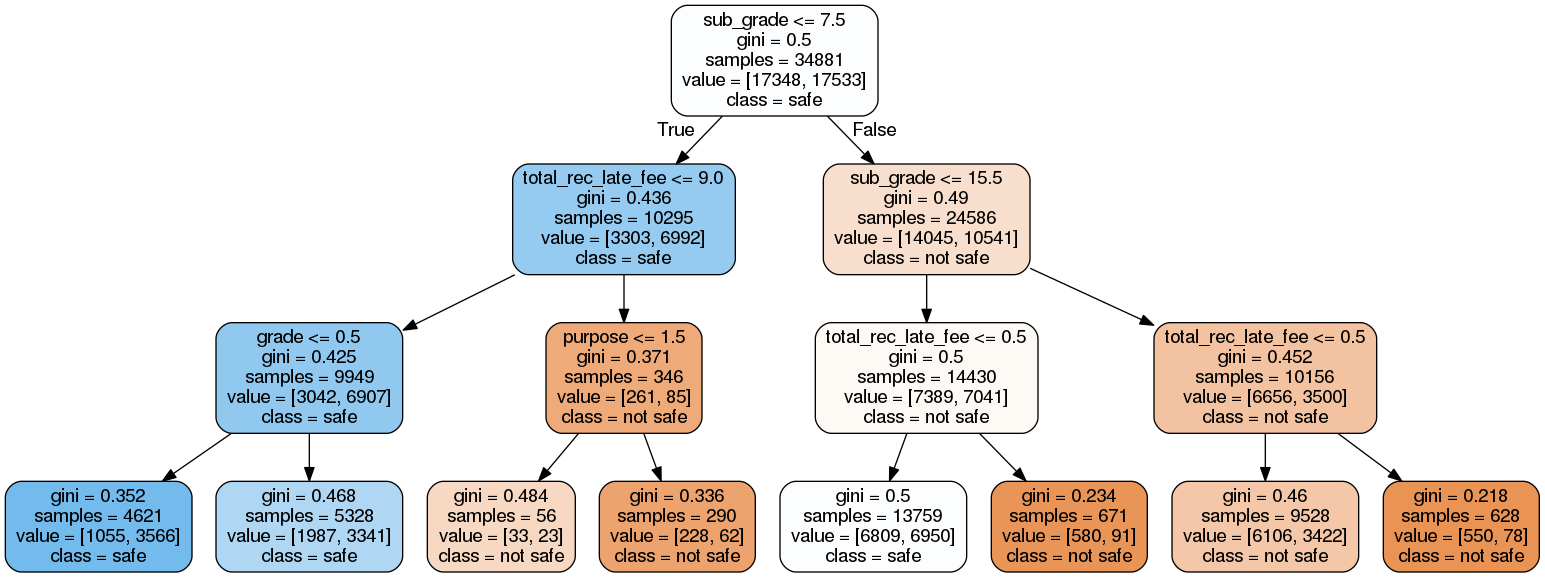

In [7]:
with open("safe-loans.dot", 'w') as f:
     f = tree.export_graphviz(clf,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(X_train),
                              class_names = ['not safe', 'safe'],
                              rounded = True,
                              filled= True )

from subprocess import check_call
check_call(['dot','-Tpng','safe-loans.dot','-o','safe-loans.png'])

from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont
img = Image.open("safe-loans.png")
draw = ImageDraw.Draw(img)
img.save('output.png')
PImage("output.png")

## 测试

欣喜若狂的你，在悄悄背诵什么？你说想把这棵决策树的判断条件背下来，然后去做贷款风险判断？

省省吧。都什么时代了，还这么喜欢背诵？

以后的决策，电脑可以自动化帮你完成了。

你不信？

我们随便从测试集里面找一条数据出来。让电脑用决策树帮我们判断一下看看。

In [8]:
test_rec = X_test.iloc[1,:]
print('电脑告诉我们，它调查后风险结果是这样的：',clf.predict([test_rec]),'之前提到过，1代表这笔贷款是安全的。实际情况如何呢？我们来验证一下。从测试集目标里面取出对应的标记：',y_test.iloc[1])

电脑告诉我们，它调查后风险结果是这样的： [1] 之前提到过，1代表这笔贷款是安全的。实际情况如何呢？我们来验证一下。从测试集目标里面取出对应的标记： 1


In [9]:
#下面我们验证一下，根据训练得来的决策树模型，贷款风险类别判断准确率究竟有多高。

from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf.predict(X_test))

0.61615205986066912

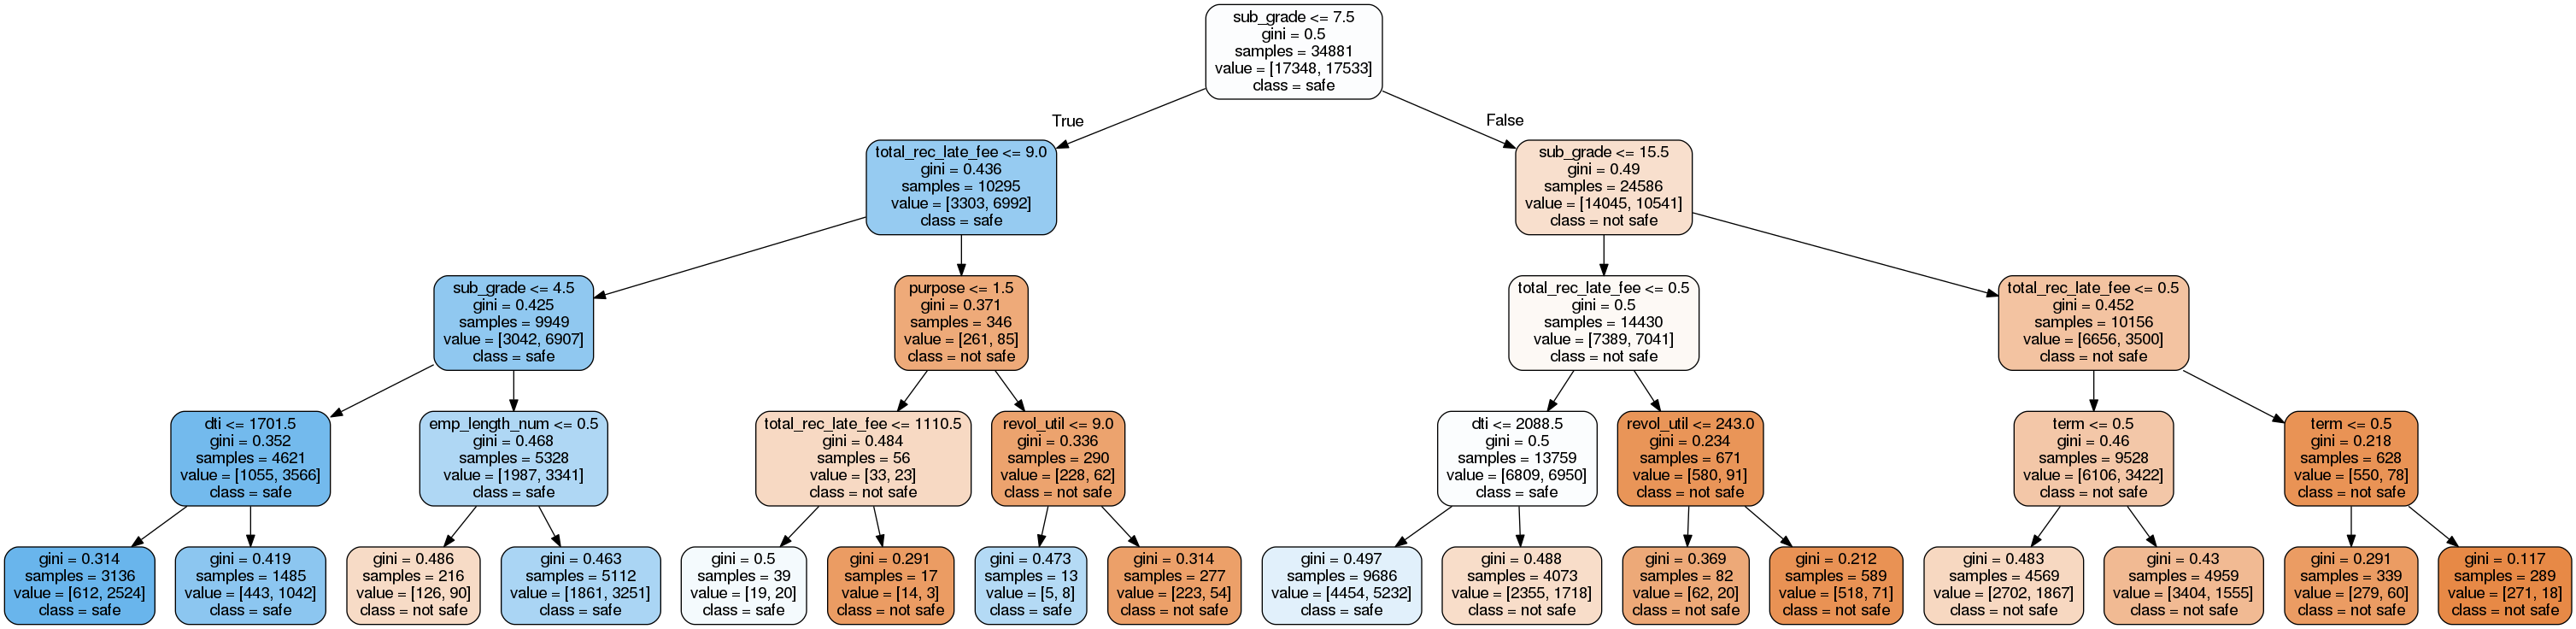

In [10]:
#模型才61%多的准确率啊，我修改一下，max_depth=4决策树深度为4看看效果
from sklearn import tree
clf2 = tree.DecisionTreeClassifier(max_depth=4)
clf2 = clf2.fit(X_train, y_train)

with open("safe-loans.dot", 'w') as f:
     f = tree.export_graphviz(clf2,
                              out_file=f,
                              max_depth = 4,
                              impurity = True,
                              feature_names = list(X_train),
                              class_names = ['not safe', 'safe'],
                              rounded = True,
                              filled= True )

from subprocess import check_call
check_call(['dot','-Tpng','safe-loans.dot','-o','safe-loans.png'])

from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont
img = Image.open("safe-loans.png")
draw = ImageDraw.Draw(img)
img.save('output.png')
PImage("output.png")

In [11]:
#下面我们验证一下，根据max_depth=4决策树深度为4的决策树模型，贷款风险类别判断准确率究竟有多高。

from sklearn.metrics import accuracy_score
accuracy_score(y_test, clf2.predict(X_test))

0.63421346865055472

才从61%增加到了63%没啥进步啊。。。。。改成5\6\7\8\9\10试试看？要不我1~10全部都做一下试试看

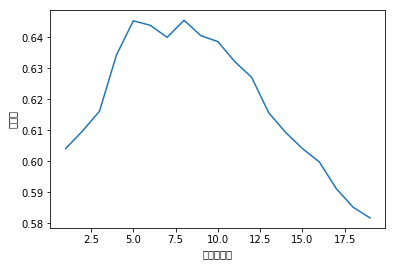

In [12]:
from sklearn import tree
from sklearn.metrics import accuracy_score
clfi=[0]*21
k_range = range(1,20)
test_accuracy = []
for i in k_range:
    test_accuracy.append(accuracy_score(y_test, tree.DecisionTreeClassifier(max_depth=i).fit(X_train, y_train).predict(X_test)))

# 然后画图，看运行正确率多少
import matplotlib.pyplot as plt
plt.plot(k_range, test_accuracy)
plt.xlabel("决策树深度")
plt.ylabel("准确率")
plt.show()

为什么决策树深度增加而准确率下降了呢？我也不知道。
我用神经网络重新做了计算
## 使用KNN算法

In [13]:
from sklearn.neighbors import KNeighborsClassifier
# K=5

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
y_pred = knn5.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.556377397437


KNN算法准确率也才55%多，我们能找到一个比较好的K值吗？

### 测试从K=1到K=25，记录测试准确率

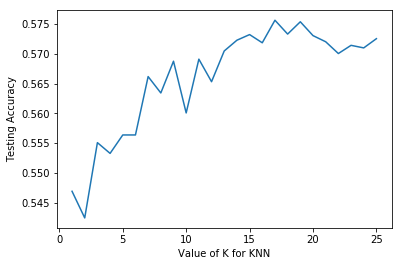

In [14]:
k_range = range(1, 26)
test_accuracy = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, y_pred))

# 然后画图，看运行正确率多少
import matplotlib.pyplot as plt
plt.plot(k_range, test_accuracy)
plt.xlabel("Value of K for KNN")
plt.ylabel("Testing Accuracy")
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_trans, y, random_state=1)

y_train=0.5*(y_train+1) # y输出范围从0到1
y_test=0.5*(y_test+1) # y输出范围从0到1

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

model = Sequential() #建立模型,快速开始序贯（Sequential）模型,序贯模型是多个网络层的线性堆叠，也就是“一条路走到黑”。

model.add(Dense(input_dim = 12, output_dim = 96)) #添加输入层、隐藏层的连接
model.add(Activation('tanh')) #以Tanh函数为激活函数

model.add(Dense(input_dim = 96, output_dim = 48)) #添加隐藏层、隐藏层的连接
model.add(Activation('relu')) #以Relu函数为激活函数
model.add(Dropout(0.1))

model.add(Dense(input_dim = 48, output_dim = 48)) #添加隐藏层、隐藏层的连接
model.add(Activation('relu')) #以Relu函数为激活函数

model.add(Dense(input_dim = 48, output_dim = 36)) #添加隐藏层、隐藏层的连接
model.add(Activation('relu')) #以Relu函数为激活函数
model.add(Dropout(0.15))

model.add(Dense(input_dim = 36, output_dim = 36)) #添加隐藏层、隐藏层的连接
model.add(Activation('relu')) #以Relu函数为激活函数

model.add(Dense(input_dim = 36, output_dim = 36)) #添加隐藏层、隐藏层的连接
model.add(Activation('relu')) #以Relu函数为激活函数

model.add(Dense(input_dim = 36, output_dim = 12)) #添加隐藏层、隐藏层的连接
model.add(Activation('relu')) #以Relu函数为激活函数

model.add(Dense(input_dim = 12, output_dim = 1)) #添加隐藏层、输出层的连接
model.add(Activation('sigmoid')) #以sigmoid函数为激活函数

#编译模型，损失函数为binary_crossentropy（之前是mean_squared_error），用adam法求解
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train.values, y_train.values, epochs=170, batch_size = 2000, verbose=False) #训练模型,epochs训练170次
   
   

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=96, input_dim=12)`
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=48, input_dim=96)`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=48, input_dim=48)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=36, input_dim=48)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=36, input_dim=36)`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(unit

In [16]:
r = pd.DataFrame(model.predict_classes(x_test.values))
'''
r = pd.DataFrame(model.predict(x_test.values))
rr=r.values
tr=rr.flatten()

for i in range(tr.shape[0]):
    if tr[i]>0.5:
        tr[i]=1
    else:

        tr[i]=0
'''     

from sklearn.metrics import accuracy_score
print('# 模型评分，正确率：',accuracy_score(y_test,r))

11168/11627 [===========================>..] - ETA: 0s# 模型评分，正确率： 0.643072159628


### 之前的版本正确率是63%，现在的正确率居然有64%，折腾好几天了，实在有点受不了了

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#画出模型结构图，并保存成图片
SVG(model_to_dot(model).create(prog='dot', format='svg'))
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [18]:
y_train.tail()

43723    1.0
32511    1.0
5192     0.0
12172    0.0
33003    1.0
Name: safe_loans, dtype: float64

In [19]:
y_test.tail()

8057     0.0
16632    0.0
30641    1.0
31072    1.0
38678    0.0
Name: safe_loans, dtype: float64

In [20]:
model.evaluate(x=x_test.values, y=y_test.values, batch_size=200, verbose=1, sample_weight=None)

11600/11627 [============================>.] - ETA: 0s

[0.63897416036865351, 0.64307215976173737]

In [21]:
model.metrics_names

['loss', 'acc']